In [2]:
from sideinfo_release import *
import matplotlib.pyplot as plt
import numpy as np
import timeit
import sys
import argparse


then = timeit.default_timer()

parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, default = '',  help='data path')
parser.add_argument('--dim', type=int, default = 1,  help='dimension of data')
parser.add_argument('--init', type=int, default = 5,  help='number of inits')
parser.add_argument('--out', type=str, default = 'test',  help='output_directory')
parser.add_argument('--prefix', type=str, default = 'http://localhost:8888/files',  help='url prefix')
parser.add_argument('--alpha', type=float, default = 0.05,  help='fdr')
parser.add_argument('--fdr_scale', type=float, default = 1,  help='fd scale')
parser.add_argument('--mirror', type=float, default = 1,  help='mirror')
parser.add_argument('--usedim', type=int, default = -1,  help='dimension of data')





opt = parser.parse_args(['--data', 'data/gtex_filtered3d.csv', '--init', '1', '--alpha', '0.1', '--fdr_scale', '1',  '--dim',  '3'   ])
print (opt)

fn = opt.data
dim = opt.dim




data = np.loadtxt(open(fn, "rb"), delimiter=",", skiprows=1)
x = data[:,0:dim]
p = data[:,dim]
h = data[:,dim+1]
n_samples = len(x)


if opt.usedim >= 0:
    x = x[:, opt.usedim]
    dim = 1
    
grids = None
x_prob = None

if dim == 1:
    max_x = np.max(x)
    min_x = np.min(x)
    x_prob = np.arange(min_x, max_x, (max_x - min_x)/1000.0)
    x_prob = x_prob.reshape((len(x_prob), 1))
    x_prob = Variable(torch.from_numpy(x_prob.astype(np.float32)))

elif dim == 2:
    max_x0 = np.max(x[:,0])
    min_x0 = np.min(x[:,0])
    max_x1 = np.max(x[:,1])
    min_x1 = np.min(x[:,1])
    x_prob0 = np.arange(min_x0, max_x0, (max_x0 - min_x0)/100.0)
    x_prob1 = np.arange(min_x1, max_x1, (max_x1 - min_x1)/100.0)
    X_grid, Y_grid = np.meshgrid(x_prob0, x_prob1)
    x_prob = Variable(torch.from_numpy(
    np.concatenate([[X_grid.flatten()], [Y_grid.flatten()]]).T.astype(np.float32)))
    grids = (X_grid, Y_grid)


if x_prob:
    print(x_prob.size())
    x_prob = x_prob.cuda()

#network = get_network(cuda = True, dim = dim)
#optimizer = optim.Adagrad(network.parameters(), lr = 0.01)


indices = np.random.permutation(x.shape[0])
A = [indices[:x.shape[0]/3], indices[x.shape[0]/3 : x.shape[0]/3*2], indices[x.shape[0]/3 * 2:]]
train = A
val = [A[1], A[2], A[0]]
test = [A[2], A[0], A[1]]
outputs = []
preds = []
gts = []

info = {}
info['filename'] = fn.replace('_', '\_')

loss_hists1 = []
loss_hists2 = []

efdr = np.zeros((3,3))
scales = np.zeros(3)

ninit = opt.init

bhp = BH(p, alpha = opt.alpha)[1]
lambda_param = 4/bhp
lambda_param = 5e4
print('lambda ', lambda_param)

if dim == 1:
    x = x.reshape((x.shape[0], 1))



Namespace(alpha=0.1, data='data/gtex_filtered3d.csv', dim=3, fdr_scale=1.0, init=1, mirror=1, out='test', prefix='http://localhost:8888/files', usedim=-1)
('lambda ', 50000.0)


In [3]:
dim = 1
x = x[:, 2:3]

In [4]:
def get_network(num_layers = 10, node_size = 10, dim = 1, scale = 1, cuda = False):
    
    
    class Model(nn.Module):
        def __init__(self, num_layers, node_size, dim):
            super(Model, self).__init__()
            l = []
            l.append(nn.Linear(dim,node_size))
            l.append(nn.LeakyReLU(0.1))
            for i in range(num_layers - 2):
                l.append(nn.Linear(node_size,node_size))
                l.append(nn.LeakyReLU(0.1))

            l.append(nn.Linear(node_size,1))
            #l.append(nn.Sigmoid())

            self.layers = nn.Sequential(*l)


        def forward(self, x):
            x = self.layers(x)
            #x = 0.5 * scale * x 
                
            x = scale * torch.exp(x)
            
            return x


    network = Model(num_layers, node_size, dim)
    if cuda:
        return network.cuda()
    else:
        return network

In [5]:
i = 0
networks = []
scores = []
loss_hist1_array = []
loss_hist2_array = []

network = get_network(num_layers = 10, cuda = True, dim = dim, scale = 0.00027629599999999999)
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)
train_idx = train[i]
val_idx = val[i]
test_idx = test[i]

#network init
#try:
#    p_target = opt_threshold_multi(x[train_idx,:], p[train_idx], 10, alpha = opt.alpha)
#except:
print(BH(p[train_idx], alpha = opt.alpha, n = 10623893/3))
p_target = np.ones(x[train_idx,:].shape[0]) * BH(p[train_idx], alpha = opt.alpha, n = 10623893/3)[1]


#plt.figure()
#plt.scatter(x, p_target)


(9739, 0.00027493899999999998)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def init(x, p):

    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=20)
    group = km.fit_predict(x)
    
    alpha = 0.1
    ths = []
    discs = 0
    for i in range(20):
        p_null = p[np.logical_and(group == i, p > 1-0.005)]
        p_alt = p[np.logical_and(group == i, p < 0.005)]
        th_high = 0.005
        th_low = 0

        for j in range(200):
            th = (th_high + th_low)/2
            #print th
            fd = np.sum(p_null > 1-th)
            td = np.sum(p_alt < th)
            #print fd, td*alpha, th
            if fd > td * alpha:
                th_high = th
            else:
                th_low = th

        ths.append(th)
        discs += td
        print td, fd, th
    ths = np.array(ths)
    
    dist = (x.repeat(20, axis = 1) - km.cluster_centers_.T ) ** 2
    s = np.sum(dist, axis = 1)
    prob = np.exp(-dist * 5) / np.expand_dims(np.sum(np.exp(-dist * 5), axis = 1),1)
    p_target = prob.dot(ths)
    
    return p_target

In [8]:
p_target = init(x, p)

17265 1729 0.000269
848 83 0.000446
539 53 0.000561
186 18 0.000278
1152 115 0.000475
89 8 0.000154
1213 120 0.000302
279 27 0.00031
194 19 0.000551
662 66 0.000454
182 18 0.000461
1780 177 0.000284
463 47 0.000495
754 75 0.00044
180 19 0.000433
156 16 0.00046
184 19 0.000396
3672 369 0.00033
241 25 0.000336
556 55 0.00051


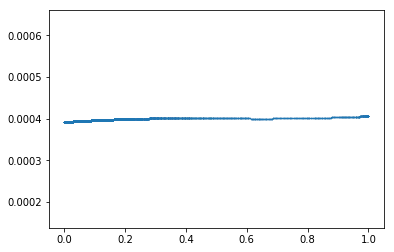

In [10]:
plt.scatter(x, p_target, 0.01)

In [11]:
#network = get_network(num_layers = 10, cuda = True, dim = 1, scale = np.mean(p_target))
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)

In [12]:
loss_hist = train_network_to_target_p(network, optimizer, x[:,0], p_target, num_it = 500, cuda= True, dim = 1)

0
100
200
300
400


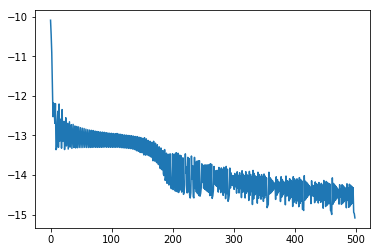

In [13]:
plt.plot(np.log(loss_hist))

In [15]:
p.shape

(169301,)

In [31]:
threshold = network(Variable(torch.from_numpy(x.astype(np.float32))).cuda())

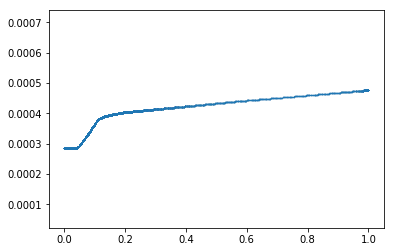

In [32]:
plt.scatter(x, threshold.cpu().data.numpy(), 0.01)

In [35]:
torch.save(network.state_dict(), 'data/gtex_dim2.th')

In [27]:
loss_hist2, s, s2 = train_network(network, optimizer, x, p, num_it = 2000, cuda = True, dim = dim, alpha = opt.alpha, lambda2_ = 5e4, fdr_scale = opt.fdr_scale, mirror = opt.mirror, lambda_ = 10)

(169301, 169301)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [28]:
s2/s

Variable containing:
 0.1001
[torch.cuda.FloatTensor of size 1 (GPU 0)]

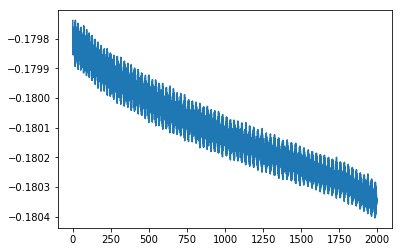

In [29]:
plt.plot(loss_hist2)

In [33]:
preds = []
n_samples = len(x)
x_input = Variable(torch.from_numpy(x.astype(np.float32).reshape(n_samples ,dim))).cuda()
p_input = Variable(torch.from_numpy(p.astype(np.float32).reshape(n_samples ,1))).cuda()
output = network.forward(x_input) 

pred = (p_input < output).cpu().data.numpy()
pred = pred[:,0].astype(np.float32)
preds.append(pred)

In [34]:
np.sum(preds)

30525.0

In [39]:
y = p_target * 100

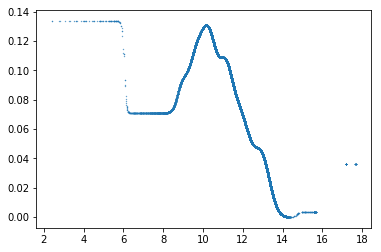

In [40]:
plt.scatter(x,y, 0.1)

In [ ]:
len(x)

In [ ]:
len(y)

In [ ]:
import torch.nn.functional as F

In [ ]:
network = get_network(cuda = True, scale = 0.07)#, scale=0.3)

In [ ]:
optimizer = torch.optim.Adagrad(network.parameters(), lr = 0.01)
l2 = nn.L1Loss(size_average=True)

In [ ]:
loss_hist = []
bt = 10000
for i in range(1000):
    choice = np.random.choice(range(169301), bt, False)
    input = Variable(torch.from_numpy(x[choice].astype(np.float32))).cuda()
    target = Variable(torch.from_numpy(y[choice].astype(np.float32))).cuda()
    network.zero_grad()
    loss = l2(network(input), target)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])
    print i

In [ ]:
plt.plot(np.log(loss_hist))

In [ ]:
input = Variable(torch.from_numpy(x.astype(np.float32))).cuda()
pred = network(input)

In [ ]:
plt.scatter(x, pred.cpu().data.numpy(), 0.1)

In [ ]:
plt.scatter(x, y, 0.1)

In [ ]:
pred = np.array(pred.cpu().data.numpy() )

In [ ]:
plt.hist(pred[:,0] - y, 100)

In [ ]:
y.shape